In [1]:
import torch
import sys
import torch.onnx
import torch.utils
import torch.utils.data
import torch.nn.functional as F
import torch.nn as nn
from model import ResNet

device = torch.device("cuda:0")

columns = 5
rows = 5
channels = 64
layers = 15
epochs = 100
training_batch_size = 64
inference_batch_size = 256
kl_loss_scale = 0.1

data_folder = "../data"
models_folder = "../models"
generation = 1

class Snapshots(torch.utils.data.Dataset):
    def __init__(self, file_name):
        self.data = [[], [], [], []]
        i = 0
        with open(file_name) as f:
            for line in f.readlines():
                if line.strip() == "":
                    i = 0
                    continue

                t = torch.tensor([float(x) for x in line.split(", ")])

                if i == 0:
                    t = t.view(7, columns, rows)
                self.data[i].append(t)
                i += 1

    def __len__(self):
        return len(self.data[0])

    def __getitem__(self, index):
        return [self.data[x][index] for x in range(4)]

In [2]:
def loss_fn(wp_out, sp_out, vs_out, wp_label, sp_label, vs_label):
    kl_div = nn.KLDivLoss(reduction='sum')
    mse = nn.MSELoss(reduction='sum')
    
    # Concatenate the outputs to form the complete action distribution
    actions_out = torch.cat([wp_out, sp_out], dim=1)
    # Apply log_softmax to convert to log probabilities
    log_probs = F.log_softmax(actions_out, dim=1)
    
    # Concatenate the labels to form the complete target distribution
    actions_label = torch.cat([wp_label, sp_label], dim=1)
    
    # Compute the KL divergence loss
    kl_loss = kl_loss_scale * kl_div(log_probs, actions_label)
    
    # Compute the MSE loss for the scalar output
    mse_loss = mse(vs_out, vs_label)

    return (kl_loss, mse_loss)


def save_model(model, folder):
    torch.save(model, f"{folder}/model_{generation}.pt")
    input_names = ["States"]
    output_names = ["WallPriors", "StepPriors", "Values"]
    dummy_input = torch.randn(inference_batch_size, 7, columns, rows).to(device)
    torch.onnx.export(
        model,
        dummy_input,
        f"{folder}/model_{generation}.onnx",
        input_names=input_names,
        output_names=output_names,
    )

In [3]:
model = ResNet(columns, rows, channels, layers).to(device)

In [4]:
training_window = range((generation - 1) // 2, generation)
snapshots = torch.utils.data.ConcatDataset(
    [Snapshots(f"{data_folder}/snapshots_{i}.csv") for i in training_window]
)
training_data, eval_data = torch.utils.data.random_split(snapshots, [0.8, 0.2])
training_loader = torch.utils.data.DataLoader(
    training_data,
    batch_size=training_batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)
eval_loader = torch.utils.data.DataLoader(
    eval_data,
    batch_size=training_batch_size,
    num_workers=4,
    pin_memory=True,
    shuffle=False,
)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.1)

In [5]:
import matplotlib.pyplot as plt

def plot_tensor(mat, cmap='viridis'):
    """
    Plots a 2D PyTorch tensor as an n x n grid of squares with colors representing the tensor values.

    Parameters:
    - mat: 2D PyTorch tensor of floats.
    - cmap: Colormap for visualizing the values in the tensor.
    """
    # Ensure mat is a 2D tensor
    if mat.dim() != 2:
        raise ValueError("Input tensor must be 2D")

    # Convert the tensor to a NumPy array
    matrix = mat.numpy()

    # Plotting the matrix
    plt.figure(figsize=(6,6))  # Adjust the figure size as needed
    plt.imshow(matrix, cmap=cmap, interpolation='nearest')  # Use specified colormap
    plt.colorbar()  # Show color scale
    plt.xticks(range(matrix.shape[0]))  # Adjust ticks based on tensor size
    plt.yticks(range(matrix.shape[1]))
    plt.grid(False)  # Turn off the grid
    plt.show()

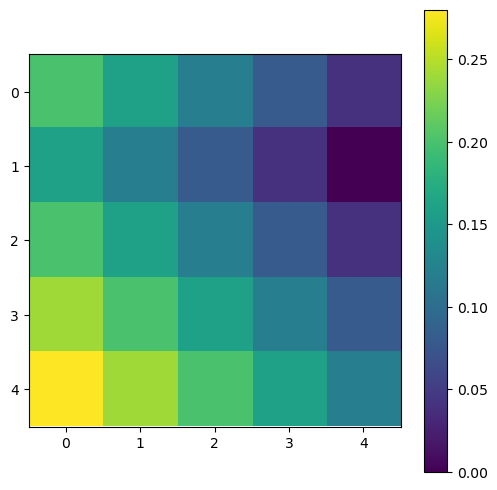

In [6]:
plot_tensor(snapshots[3][0][0])

In [7]:
len(snapshots)

3246

In [8]:


try:
    for epoch in range(1000):
        total_kl_loss = 0
        total_mse_loss = 0
        for states, wall_priors, step_priors, values in training_loader:
            states = states.to(device)
            wall_priors = wall_priors.to(device)
            step_priors = step_priors.to(device)
            values = values.to(device)
    
            optimizer.zero_grad()
            wp, sp, vs = model.forward(states)
            kl_loss, mse_loss = loss_fn(wp, sp, vs, wall_priors, step_priors, values)
            total_kl_loss += float(kl_loss)
            total_mse_loss += float(mse_loss)

            loss = kl_loss + mse_loss
            loss.backward()
            optimizer.step()
            del loss
        print(
            f"Training loss in epoch {epoch} of generation {generation}: {total_kl_loss / len(training_data)} + {total_mse_loss / len(training_data)} = {(total_kl_loss + total_mse_loss) / len(training_data)}."
        )
        
        model.train(False)
        total_kl_loss = 0
        total_mse_loss = 0
        for states, wall_priors, step_priors, values in eval_loader:
            states = states.to(device)
            wall_priors = wall_priors.to(device)
            step_priors = step_priors.to(device)
            values = values.to(device)
            wp, sp, vs = model.forward(states)
            kl_loss, mse_loss = loss_fn(wp, sp, vs, wall_priors, step_priors, values)
            total_kl_loss += float(kl_loss)
            total_mse_loss += float(mse_loss)
        print(
            f"Evaluation loss in epoch {epoch} of generation {generation}: {total_kl_loss / len(eval_data)} + {total_mse_loss / len(eval_data)} = {(total_kl_loss + total_mse_loss) / len(eval_data)}."
        )
except KeyboardInterrupt:
    print("Trainig was interrupted.")

Training loss in epoch 0 of generation 1: 0.12602440669162943 + 1.742773794145551 = 1.8687982008371804.
Evaluation loss in epoch 0 of generation 1: 0.11996891336925959 + 1.9207412178968244 = 2.040710131266084.
Training loss in epoch 1 of generation 1: 0.12496459158191232 + 1.752132966603781 = 1.8770975581856935.
Evaluation loss in epoch 1 of generation 1: 0.11996891336925959 + 1.9207412178968244 = 2.040710131266084.
Training loss in epoch 2 of generation 1: 0.12496459240816077 + 1.7521329724793255 = 1.8770975648874864.
Evaluation loss in epoch 2 of generation 1: 0.11996891336925959 + 1.9207412178968244 = 2.040710131266084.
Training loss in epoch 3 of generation 1: 0.12496459286718768 + 1.7521329695415533 = 1.8770975624087411.
Evaluation loss in epoch 3 of generation 1: 0.11996891336925959 + 1.9207412178968244 = 2.040710131266084.
Training loss in epoch 4 of generation 1: 0.12496459093927464 + 1.7521329724793255 = 1.8770975634186002.
Evaluation loss in epoch 4 of generation 1: 0.1199689

In [9]:
initial_state = torch.unsqueeze(snapshots[0][0], 0).to(device)

In [10]:
model.forward(initial_state)

(tensor([[1.2620e-05, 1.1728e-05, 9.9632e-06, 1.1068e-05, 9.7491e-06, 1.0028e-05,
          9.6527e-06, 1.0931e-05, 1.1280e-05, 9.7572e-06, 1.2101e-05, 1.2371e-05,
          1.1854e-05, 1.2051e-05, 9.7584e-06, 1.1797e-05, 1.1570e-05, 1.2146e-05,
          1.1763e-05, 9.7487e-06, 1.2140e-05, 1.0696e-05, 1.0152e-05, 1.0767e-05,
          9.7246e-06, 1.3745e-05, 1.6174e-05, 1.6068e-05, 1.2206e-05, 1.0691e-05,
          1.0049e-05, 1.0471e-05, 1.1226e-05, 1.1121e-05, 1.0335e-05, 1.1261e-05,
          1.9361e-05, 1.3077e-05, 1.1814e-05, 1.1210e-05, 1.2814e-05, 1.3772e-05,
          1.4247e-05, 1.2809e-05, 1.1578e-05, 9.7463e-06, 9.7496e-06, 9.7592e-06,
          9.7417e-06, 9.7537e-06]], device='cuda:0', grad_fn=<SigmoidBackward0>),
 tensor([[1.0000, 1.0000, 1.0000, 0.9378]], device='cuda:0',
        grad_fn=<SigmoidBackward0>),
 tensor([[0.1639]], device='cuda:0', grad_fn=<TanhBackward0>))

In [11]:
snapshots[0]

[tensor([[[0.0000, 0.0400, 0.0800, 0.1200, 0.1600],
          [0.0400, 0.0800, 0.1200, 0.1600, 0.2000],
          [0.0800, 0.1200, 0.1600, 0.2000, 0.2400],
          [0.1200, 0.1600, 0.2000, 0.2400, 0.2800],
          [0.1600, 0.2000, 0.2400, 0.2800, 0.3200]],
 
         [[0.3200, 0.2800, 0.2400, 0.2000, 0.1600],
          [0.2800, 0.2400, 0.2000, 0.1600, 0.1200],
          [0.2400, 0.2000, 0.1600, 0.1200, 0.0800],
          [0.2000, 0.1600, 0.1200, 0.0800, 0.0400],
          [0.1600, 0.1200, 0.0800, 0.0400, 0.0000]],
 
         [[0.1600, 0.1200, 0.0800, 0.0400, 0.0000],
          [0.2000, 0.1600, 0.1200, 0.0800, 0.0400],
          [0.2400, 0.2000, 0.1600, 0.1200, 0.0800],
          [0.2800, 0.2400, 0.2000, 0.1600, 0.1200],
          [0.3200, 0.2800, 0.2400, 0.2000, 0.1600]],
 
         [[0.1600, 0.2000, 0.2400, 0.2800, 0.3200],
          [0.1200, 0.1600, 0.2000, 0.2400, 0.2800],
          [0.0800, 0.1200, 0.1600, 0.2000, 0.2400],
          [0.0400, 0.0800, 0.1200, 0.1600, 0.2000],
   

In [12]:
save_model(model, models_folder)